In [71]:
import pandas as pd

In [72]:
path = '/home/aiops/zhuty/tinyllama/scripts/fewshot_eval/results/rag_outputs.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,task,n_shot,seed,model,score,num_docs
0,0,nq_obqa,3,42,/home/aiops/zhuty/tinyllama/out_hf/tiny_LLaMA_...,12.770083,1
1,1,nq_obqa,3,43,/home/aiops/zhuty/tinyllama/out_hf/tiny_LLaMA_...,15.678670,1
2,2,nq_obqa,3,44,/home/aiops/zhuty/tinyllama/out_hf/tiny_LLaMA_...,12.770083,1
3,3,nq_obqa,3,45,/home/aiops/zhuty/tinyllama/out_hf/tiny_LLaMA_...,14.598338,1
4,4,nq_obqa,3,46,/home/aiops/zhuty/tinyllama/out_hf/tiny_LLaMA_...,11.578947,1


In [73]:
selected_task = 'tq_obqa'
df = df[df['task'] == selected_task]
df = df[df['num_docs'] <=10]
print(len(df))

73


In [74]:
def extract_pretrain_dataset(x):
    """
    Sample input: /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_8k/iter-200000-ckpt-step-25000_hf
    Sample output: cc_8k
    Args:
        x:
    Returns:

    """
    if '/home/aiops/zhuty' in x:
        folder_name = x.split('/')[-2] # tiny_LLaMA_1b_8k_cc_8k
        return ("_").join(folder_name.split('_')[4:]) # cc_8k
    else:
        # sample model name: tyzhu/tiny_LLaMA_120M_8k_cc_8k_iter-240000-ckpt-step-60000_hf
        return x.strip("tyzhu/").split("_8k_")[1]

name_to_meaning_map = {"cc_8k": "random", "intramask_cc_8k": "intradoc", "cc_merged_v1_8k": "dense", "cc_merged_v2_8k": "bm25"}

df['model'] = df['model'].apply(extract_pretrain_dataset)
df['model'] = df['model'].map(name_to_meaning_map)

In [75]:
grouped_df = df.groupby(['model', 'task', 'num_docs' ]).agg({'score': ['mean', 'std']})

In [76]:
grouped_df

score          
                                mean       std
model    task    num_docs                     
bm25     tq_obqa 1         35.776540  1.573791
                 3         32.320339  2.703904
                 5         30.982056  3.064362
                 10        26.394413  2.746770
dense    tq_obqa 1         34.045788  1.404192
                 3         33.128259  1.415316
                 5         28.956068  4.320397
                 10        21.641769  3.019920
intradoc tq_obqa 1         33.259082  1.107883
                 3         23.650667  2.615851
                 5         18.640502  2.689437
                 10         6.023159  3.400641
random   tq_obqa 1         34.213737  1.161003
                 3         31.662689  2.515431
                 5         23.866349  3.875107
                 10        12.012729       NaN

In [77]:
# visualize as a line plot
import matplotlib.pyplot as plt
import seaborn as sns

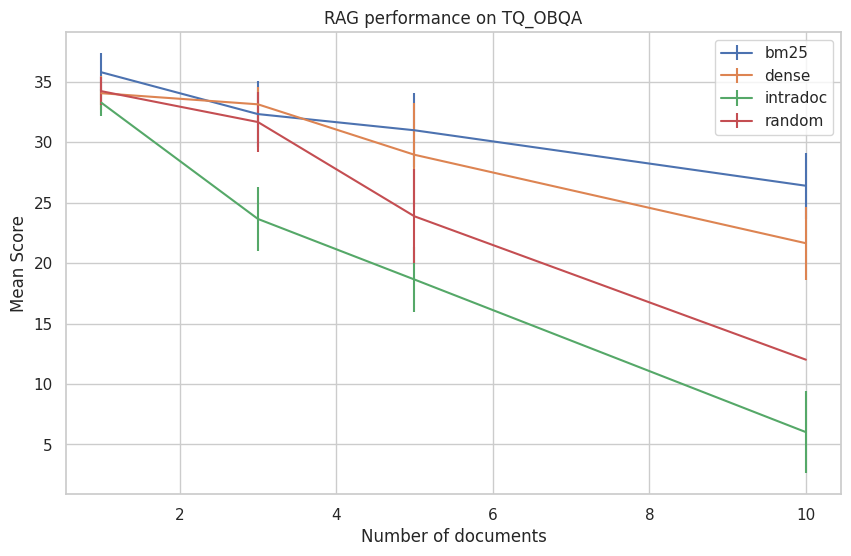

In [78]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# plot the mean and the standard deviation
for model in grouped_df.index.get_level_values(0).unique():
    for task in grouped_df.index.get_level_values(1).unique():
        df_to_plot = grouped_df.loc[(model, task)]
        plt.errorbar(df_to_plot.index.get_level_values(0), df_to_plot['score']['mean'], yerr=df_to_plot['score']['std'], label=model)
plt.title('RAG performance on {}'.format(selected_task.upper()))
plt.ylabel('Mean Score')
plt.xlabel('Number of documents')
plt.legend()
plt.show()